<h1>Instalacoes</h1>

In [1]:
!pip3 install openai

In [2]:
!pip3 install tiktoken

<h1>Importacoes</h1>

In [3]:
import os
import openai
import tiktoken
import time
import numpy as np
import pandas as pd
from openai.embeddings_utils import get_embedding, cosine_similarity

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

<h1>Análise Exploratória</h1>

<h2>Cursos</h2>

In [4]:
df = pd.read_csv("../data/cursos.csv")
df.head()

,Unnamed: 0,Nome Curso,Descrição,Materias,Tipo,Duração
0,0,marketing,['Marketing é o conjunto de estratégias e açõe...,"['Administração de Compras e Vendas', 'Adminis...",grad,8
1,1,comunicacao-social,['A Comunicação Social é a área da Ciência Soc...,"['Antropologia e Cultura Brasileira', 'Cibercu...",grad,8
2,2,engenharia-ambiental,['A Engenharia Ambiental é a área da engenhari...,['América Latina e Sustentabilidade Socioambie...,grad,10
3,3,gestao-ambiental,['É a prática de gerenciar os recursos naturai...,"['Atividades Complementares', 'Auditoria e Cer...",grad ou tec,6
4,4,psicologia,"[""Psicologia é a ciência dedicada ao estudo da...","['Antropologia', 'Bases Epistemológicas da Psi...",grad,10


In [5]:
df.shape

(13, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13 non-null     int64 
 1   Nome Curso  13 non-null     object
 2   Descrição   13 non-null     object
 3   Materias    13 non-null     object
 4   Tipo        13 non-null     object
 5   Duração     13 non-null     object
dtypes: int64(1), object(5)
memory usage: 752.0+ bytes


In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(1)

,Nome Curso,Descrição,Materias,Tipo,Duração
0,marketing,['Marketing é o conjunto de estratégias e açõe...,"['Administração de Compras e Vendas', 'Adminis...",grad,8


In [8]:
df.columns = ['nome_curso', 'descricao', 'materias', 'tipo', 'duracao']
df.columns

Index(['nome_curso', 'descricao', 'materias', 'tipo', 'duracao'], dtype='object')

In [18]:
df.nome_curso.nunique()

13

In [11]:
df.descricao.loc[0]

"['Marketing é o conjunto de estratégias e ações que visam criar valor para o cliente e gerar lucro para a empresa. Envolve atividades como pesquisa de mercado, desenvolvimento de produtos, comunicação, promoção e distribuição, com o objetivo de identificar, satisfazer e fidelizar, garantindo a competitividade e o sucesso da empresa no mercado.\\nA faculdade de Marketing é constituída por disciplinas que desenvolvem habilidades e conhecimentos para o estudante se tornar um profissional de marketing. Com o curso, o aluno tem a oportunidade de aprofundar seu conhecimento em diversos tópicos, como estratégias de marketing, técnicas de publicidade, planejamento e gestão de marketing, estudos de mercado e análise de dados, além de outras áreas.\\nO termo marketing é derivado da palavra mark, que, do inglês, significado mercado. A nomenclatura define os conceitos básicos da área, que consiste no estudo e desenvolvimento de ações de mercado.\\nDurante o curso de Marketing, o formando aprende 

In [12]:
type(df.descricao.loc[0])

str

In [15]:
def transforma_descricao(string):
    
    string = string.replace("\\n", "")
    string = string.replace("']", "")
    string = string.replace("['", "")
    string = string.replace('["', '')
    string = string.replace('"]', '')
    return string

In [16]:
df['descricao'] = df['descricao'].map(transforma_descricao)
df.descricao.loc[0]

"Marketing é o conjunto de estratégias e ações que visam criar valor para o cliente e gerar lucro para a empresa. Envolve atividades como pesquisa de mercado, desenvolvimento de produtos, comunicação, promoção e distribuição, com o objetivo de identificar, satisfazer e fidelizar, garantindo a competitividade e o sucesso da empresa no mercado.A faculdade de Marketing é constituída por disciplinas que desenvolvem habilidades e conhecimentos para o estudante se tornar um profissional de marketing. Com o curso, o aluno tem a oportunidade de aprofundar seu conhecimento em diversos tópicos, como estratégias de marketing, técnicas de publicidade, planejamento e gestão de marketing, estudos de mercado e análise de dados, além de outras áreas.O termo marketing é derivado da palavra mark, que, do inglês, significado mercado. A nomenclatura define os conceitos básicos da área, que consiste no estudo e desenvolvimento de ações de mercado.Durante o curso de Marketing, o formando aprende a desenvolv

<h1>Modelo</h1>

In [27]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [19]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"
max_tokens = 8000 

In [20]:
encoding = tiktoken.get_encoding(embedding_encoding)

In [22]:
df["n_tokens"] = df.descricao.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]
len(df)

13

In [23]:
df.head()

,nome_curso,descricao,materias,tipo,duracao,n_tokens
0,marketing,Marketing é o conjunto de estratégias e ações ...,"['Administração de Compras e Vendas', 'Adminis...",grad,8,2649
1,comunicacao-social,A Comunicação Social é a área da Ciência Socia...,"['Antropologia e Cultura Brasileira', 'Cibercu...",grad,8,1231
2,engenharia-ambiental,A Engenharia Ambiental é a área da engenharia ...,['América Latina e Sustentabilidade Socioambie...,grad,10,3227
3,gestao-ambiental,É a prática de gerenciar os recursos naturais ...,"['Atividades Complementares', 'Auditoria e Cer...",grad ou tec,6,2662
4,psicologia,"[""Psicologia é a ciência dedicada ao estudo da...","['Antropologia', 'Bases Epistemológicas da Psi...",grad,10,4789


In [28]:
%%time
df["embedding"] = df.descricao.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("../data/Model_embedding_Cursos.csv")

CPU times: user 176 ms, sys: 5.02 ms, total: 181 ms
Wall time: 13.9 s


In [29]:
df.head()

,nome_curso,descricao,materias,tipo,duracao,n_tokens,embedding
0,marketing,Marketing é o conjunto de estratégias e ações ...,"['Administração de Compras e Vendas', 'Adminis...",grad,8,2649,"[-0.023170089349150658, -0.0017355696763843298..."
1,comunicacao-social,A Comunicação Social é a área da Ciência Socia...,"['Antropologia e Cultura Brasileira', 'Cibercu...",grad,8,1231,"[-0.01699669472873211, 0.009934777393937111, 0..."
2,engenharia-ambiental,A Engenharia Ambiental é a área da engenharia ...,['América Latina e Sustentabilidade Socioambie...,grad,10,3227,"[0.019423266872763634, -0.008352257311344147, ..."
3,gestao-ambiental,É a prática de gerenciar os recursos naturais ...,"['Atividades Complementares', 'Auditoria e Cer...",grad ou tec,6,2662,"[0.01468762569129467, -0.003767862217500806, 0..."
4,psicologia,"[""Psicologia é a ciência dedicada ao estudo da...","['Antropologia', 'Bases Epistemológicas da Psi...",grad,10,4789,"[-0.0025111641734838486, 0.016500156372785568,..."


In [30]:
matrix = np.array(df.embedding.tolist())

In [44]:
n_clusters = 7

In [45]:
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)

KMeans(n_clusters=7, random_state=42)

In [46]:
labels = kmeans.labels_
df["Cluster"] = labels 

In [47]:
df.head()

,nome_curso,descricao,materias,tipo,duracao,n_tokens,embedding,Cluster
0,marketing,Marketing é o conjunto de estratégias e ações ...,"['Administração de Compras e Vendas', 'Adminis...",grad,8,2649,"[-0.023170089349150658, -0.0017355696763843298...",5
1,comunicacao-social,A Comunicação Social é a área da Ciência Socia...,"['Antropologia e Cultura Brasileira', 'Cibercu...",grad,8,1231,"[-0.01699669472873211, 0.009934777393937111, 0...",6
2,engenharia-ambiental,A Engenharia Ambiental é a área da engenharia ...,['América Latina e Sustentabilidade Socioambie...,grad,10,3227,"[0.019423266872763634, -0.008352257311344147, ...",4
3,gestao-ambiental,É a prática de gerenciar os recursos naturais ...,"['Atividades Complementares', 'Auditoria e Cer...",grad ou tec,6,2662,"[0.01468762569129467, -0.003767862217500806, 0...",4
4,psicologia,"[""Psicologia é a ciência dedicada ao estudo da...","['Antropologia', 'Bases Epistemológicas da Psi...",grad,10,4789,"[-0.0025111641734838486, 0.016500156372785568,...",0


In [55]:
df[df['Cluster'] == 1]

,nome_curso,descricao,materias,tipo,duracao,n_tokens,embedding,Cluster
5,ciencia-da-computacao,A Ciência da Computação é o campo que estuda o...,"['Algoritmos e Programação', 'Análise e Projet...",grad,8,2392,"[0.007760383188724518, 0.010176828131079674, 0...",1
6,tecnologia-da-informacao,A Tecnologia da Informação (TI) é o estudo da ...,"['Banco de Dados', 'Comércio Eletrônico', 'Con...",tec,4,1669,"[-0.01176544837653637, -0.0034622945822775364,...",1
8,redes-de-computadores,O curso de Redes de Computadores forma profiss...,"['Administração de Banco de Dados', 'Arquitetu...",grad ou tec,6,797,"[-0.012087889015674591, -0.016670309007167816,...",1
10,analise-e-desenvolvimento-de-sistemas,Análise e Desenvolvimento de Sistemas é a área...,"Análise de Sistemas Orientada a Objetos,Ativid...",grad,4-6,2841,"[-0.0014441859675571322, 0.003661047201603651,...",1


In [49]:
tsne = TSNE(n_components=2, perplexity=15, random_state=11, init='random', learning_rate=200) 

In [50]:
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(13, 2)

In [51]:
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

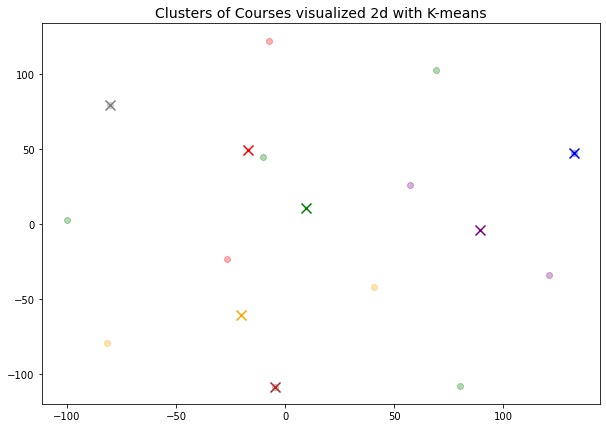

In [54]:
fig, ax = plt.subplots(figsize=(10, 7))
for category, color in enumerate(["purple", "green", "red", "blue", "orange", 'brown', 'gray', ]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    ax.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()
    ax.scatter(avg_x, avg_y, marker="x", color=color, s=100)

ax.set_title("Clusters of Courses visualized 2d with K-means", fontsize=14)
plt.show()

In [53]:
rev_per_cluster = 1
for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .descricao.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=90,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    print("-" * 100)

Cluster 0 Theme:  The reviews all discuss the field of psychoanalytic psychology, including the benefits of taking a course in psychoanalytic psychology, the skills and knowledge required to become a psychoanalyst, and the types of services a psychoanalyst can provide.
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  The common theme of these customer reviews is Tecnology of Information (TI). They discuss the course of Tecnology of Information, the value of the course, the professional of Tecnology of Information, the curriculum of the course, and the requirements to become a professional of Tecnology of Information.
----------------------------------------------------------------------------------------------------
Cluster 2 Theme: 

InvalidRequestError: This model's maximum context length is 4097 tokens, however you requested 5923 tokens (5833 in your prompt; 90 for the completion). Please reduce your prompt; or completion length.

<h2>Persistindo o Modelo</h2>

In [56]:
import pickle

In [57]:
with open('models/kmeans.pkl', 'wb') as arquivo:
    pickle.dump(kmeans, arquivo)

<h1>Profissoes</h1>

In [59]:
df_2 = pd.read_csv("../data/profissoes.csv")
df_2.head()

,Unnamed: 0,Nome Curso,Descrição,Cursos
0,0,devops,['Aquele que otimiza a produtividade das opera...,"ciencia-da-computacao, analise-e-desenvolvimen..."
1,1,professor,['Aquele que transmite conhecimento e aprendiz...,"historia, pedagogia"
2,2,cientista-de-dados,['Aquele que trabalha com uma infinidade de in...,ciencia-da-computacao
3,3,psicologo-comportamental,['Profissional especializado na compreensão e ...,"psicologia, medicina, psicanalise"
4,4,analista-ambiental,['Aquele que organiza e implementa estratégias...,"engenharia-ambiental, gestao-ambiental"


In [60]:
df_2.drop(columns=['Unnamed: 0'], inplace=True)
df_2.head(1)

,Nome Curso,Descrição,Cursos
0,devops,['Aquele que otimiza a produtividade das opera...,"ciencia-da-computacao, analise-e-desenvolvimen..."


In [61]:
df_2.columns = ['nome_curso', 'descricao', 'cursos']
df_2.columns

Index(['nome_curso', 'descricao', 'cursos'], dtype='object')

In [62]:
df_2.nome_curso.nunique()

6

In [63]:
df_2.descricao.loc[0]

'[\'Aquele que otimiza a produtividade das operações na área de Tecnologia da Informação. Profissional tem ganhado espaço no mercado e precisa estar antenado nas novidades constantes que surgem na área\', \'O profissional especialista em DevOps (Desenvolvimento & Operações, de maneira simplificada) é aquele que atua na integração entre as equipes de desenvolvimento de software, especialmente nas áreas de desenvolvimento e operações, integrando e monitorando suas atividades para buscar um desempenho mais otimizado e simplificado.Os especialistas em DevOps devem promover a padronização dos processos em Tecnologia da Informação, buscando liberação mais rápida de atualizações de novas versões do produto, por meio de uso de metodologias ágeis, ferramentas de produtividade. Mas, além disso, é função desse profissional implementar uma nova cultura nos espaços de trabalho, com base na priorização dos indivíduos e das interações acima dos processos, do bom funcionamento dos softwares desenvolvi

In [90]:
def new_transforma_descricao(string):
    string = string.replace("\\n", "")
    string = string.replace("']", "")
    string = string.replace("['", "")
    string = string.replace('["', '')
    string = string.replace('"]', '')
    string = string.replace('\\xa0', '')
    string = string.replace("\\", "")
    string = string.replace("[\'", "")
    string = string.replace("\'", "")
    string = string.replace("\n", "")
    
    return string

In [70]:
df_2['descricao'] = df_2['descricao'].map(new_transforma_descricao)
df_2.descricao.loc[0]

'Aquele que otimiza a produtividade das operações na área de Tecnologia da Informação. Profissional tem ganhado espaço no mercado e precisa estar antenado nas novidades constantes que surgem na área, O profissional especialista em DevOps (Desenvolvimento & Operações, de maneira simplificada) é aquele que atua na integração entre as equipes de desenvolvimento de software, especialmente nas áreas de desenvolvimento e operações, integrando e monitorando suas atividades para buscar um desempenho mais otimizado e simplificado.Os especialistas em DevOps devem promover a padronização dos processos em Tecnologia da Informação, buscando liberação mais rápida de atualizações de novas versões do produto, por meio de uso de metodologias ágeis, ferramentas de produtividade. Mas, além disso, é função desse profissional implementar uma nova cultura nos espaços de trabalho, com base na priorização dos indivíduos e das interações acima dos processos, do bom funcionamento dos softwares desenvolvidos, da

In [71]:
df_2["n_tokens"] = df_2.descricao.apply(lambda x: len(encoding.encode(x)))
df_2 = df_2[df_2.n_tokens <= max_tokens]
len(df_2)

6

In [72]:
df_2.head()

,nome_curso,descricao,cursos,n_tokens
0,devops,Aquele que otimiza a produtividade das operaçõ...,"ciencia-da-computacao, analise-e-desenvolvimen...",1562
1,professor,Aquele que transmite conhecimento e aprendizad...,"historia, pedagogia",2224
2,cientista-de-dados,Aquele que trabalha com uma infinidade de info...,ciencia-da-computacao,2587
3,psicologo-comportamental,Profissional especializado na compreensão e mo...,"psicologia, medicina, psicanalise",2283
4,analista-ambiental,Aquele que organiza e implementa estratégias p...,"engenharia-ambiental, gestao-ambiental",1695


In [73]:
%%time
df_2["embedding"] = df_2.descricao.apply(lambda x: get_embedding(x, engine=embedding_model))
df_2.to_csv("../data/Model_embedding_Profissoes.csv")

CPU times: user 109 ms, sys: 779 µs, total: 109 ms
Wall time: 6.06 s


In [74]:
matrix_2 = np.array(df_2.embedding.tolist())

In [75]:
n_clusters_2 = 6

In [78]:
kmeans_2 = KMeans(n_clusters=n_clusters_2, init="k-means++", random_state=42)
kmeans_2.fit(matrix_2)

KMeans(n_clusters=6, random_state=42)

In [79]:
labels = kmeans_2.labels_
df_2["Cluster"] = labels 

In [80]:
df_2.head()

,nome_curso,descricao,cursos,n_tokens,embedding,Cluster
0,devops,Aquele que otimiza a produtividade das operaçõ...,"ciencia-da-computacao, analise-e-desenvolvimen...",1562,"[-0.004839891567826271, -0.0001442406355636194...",2
1,professor,Aquele que transmite conhecimento e aprendizad...,"historia, pedagogia",2224,"[-0.005933306645601988, 0.010552989318966866, ...",4
2,cientista-de-dados,Aquele que trabalha com uma infinidade de info...,ciencia-da-computacao,2587,"[-0.02413325197994709, 0.009161577560007572, 0...",3
3,psicologo-comportamental,Profissional especializado na compreensão e mo...,"psicologia, medicina, psicanalise",2283,"[-0.02025003731250763, 0.015865236520767212, 0...",0
4,analista-ambiental,Aquele que organiza e implementa estratégias p...,"engenharia-ambiental, gestao-ambiental",1695,"[0.00784892775118351, -0.0024344439152628183, ...",5


In [127]:
df_2.to_csv("../data/Model_embedding_Profissoes.csv")

In [81]:
tsne_2 = TSNE(n_components=2, perplexity=15, random_state=11, init='random', learning_rate=200) 

In [82]:
vis_dims = tsne_2.fit_transform(matrix_2)
vis_dims.shape

(6, 2)

In [83]:
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

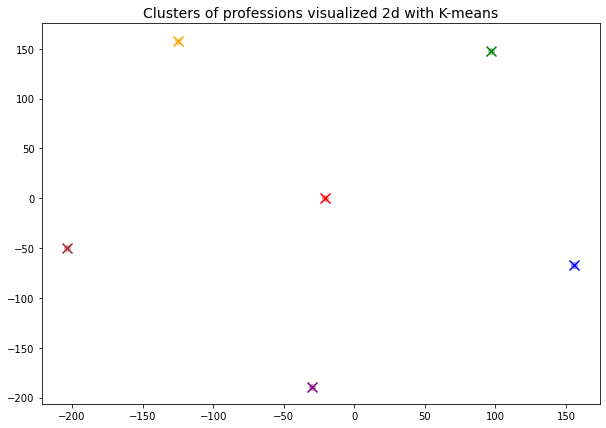

In [84]:
fig, ax = plt.subplots(figsize=(10, 7))
for category, color in enumerate(["purple", "green", "red", "blue", "orange", 'brown']):
    xs = np.array(x)[df_2.Cluster == category]
    ys = np.array(y)[df_2.Cluster == category]
    ax.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()
    ax.scatter(avg_x, avg_y, marker="x", color=color, s=100)

ax.set_title("Clusters of professions visualized 2d with K-means", fontsize=14)
plt.show()

In [86]:
rev_per_cluster = 1
for i in range(n_clusters_2):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df_2[df_2.Cluster == i]
        .descricao.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=90,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    print("-" * 100)

Cluster 0 Theme:  The reviews all discuss the profession of a behavioral psychologist, including the educational requirements, the techniques used, and the environments in which they work.
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  The reviews all discuss the role of an analyst of digital marketing, the strategies they use, and the skills and qualifications needed to become one. They also mention the salary of an analyst of digital marketing and the Quero Bolsa website, which offers discounts on courses related to digital marketing.
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  The reviews all discuss the profession of DevOps, its role in the technology industry, the tools used, and the salary and educational requirements for the profession.
---------------------------------------------------------------------------------------------------

<h2>Predict</h2>

In [112]:
profissao = 'gosto de trabalhar com computadores, programacao, matematica e estatistica'

In [113]:
profissao

'gosto de trabalhar com computadores, programacao, matematica e estatistica'

In [114]:
profissao = new_transforma_descricao(profissao)
profissao

'gosto de trabalhar com computadores, programacao, matematica e estatistica'

In [115]:
embedding = get_embedding(profissao, engine=embedding_model)
embedding

[-0.01315920427441597,
 -0.002186379861086607,
 -0.005361273884773254,
 -0.03901169076561928,
 -0.00173147430177778,
 0.004347574431449175,
 -0.02556285634636879,
 -0.0037336882669478655,
 -0.008468483574688435,
 -0.009242924861609936,
 0.025991003960371017,
 0.010986991226673126,
 0.014204385690391064,
 -0.011685877107083797,
 -0.012006986886262894,
 0.0009389313054271042,
 0.025210265070199966,
 -0.0003763989079743624,
 0.006774786859750748,
 -0.017780667170882225,
 -0.005547014065086842,
 0.01950584538280964,
 0.01605548895895481,
 -0.02601618878543377,
 -0.015186604112386703,
 -0.004212204832583666,
 -0.007908115163445473,
 -0.022452499717473984,
 0.015022900886833668,
 -0.010722547769546509,
 0.03901169076561928,
 -0.014846605248749256,
 -0.0204376932233572,
 -0.028962843120098114,
 -0.0378531776368618,
 -0.011452915146946907,
 0.010640696622431278,
 0.008260706439614296,
 -0.0007083304226398468,
 -0.00223045377060771,
 -0.00685034180060029,
 0.014242162927985191,
 -0.002787673613

In [116]:
matrix_3 = np.array(embedding)

In [117]:
matrix_3

array([-0.0131592 , -0.00218638, -0.00536127, ..., -0.00113412,
        0.00231388, -0.00132773])

In [118]:
matrix_3 = matrix_3.reshape(1, -1)

In [119]:
matrix_3

array([[-0.0131592 , -0.00218638, -0.00536127, ..., -0.00113412,
         0.00231388, -0.00132773]])

In [122]:
predict = kmeans_2.predict(matrix_3)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f37ec198790>
Traceback (most recent call last):
  File "/home/chris/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/chris/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/chris/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/chris/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [125]:
predict[0]

3

In [124]:
df_2[df_2['Cluster'] == 3]

,nome_curso,descricao,cursos,n_tokens,embedding,Cluster
2,cientista-de-dados,Aquele que trabalha com uma infinidade de info...,ciencia-da-computacao,2587,"[-0.02413325197994709, 0.009161577560007572, 0...",3


In [126]:
with open('models/kmeans_profissoes.pkl', 'wb') as arquivo:
    pickle.dump(kmeans_2, arquivo)